# **Assignment 2: Activity recognition**
#### Yuna Watanabe

## **Data structure**
The data used are included in `./data` repository. 

## **Import libraries**

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import time

## **Load data**

In [2]:
data_dir = './data/'
filename = 'WISDM_ar_v1.1_raw.txt'

# Sampling frequency
fs = 20 

# Read txt file
with open(data_dir + filename, 'r') as f:
    data = f.readlines()

# Split data by comma
data_splitted = [line.split(';') for line in data if len(line.split(',')) == 6]
data_splitted = [entry[0].split(',') for entry in data_splitted]

In [3]:
# Create a DataFrame
data_df = pd.DataFrame({
    'user': [entry[0] for entry in data_splitted],
    'activity': [entry[1] for entry in data_splitted],
    'timestamp': [entry[2] for entry in data_splitted],
    'x-acc': [entry[3] for entry in data_splitted],
    'y-acc': [entry[4] for entry in data_splitted],
    'z-acc': [entry[5] for entry in data_splitted] # Remove ';\n'
})
data_df

,user,activity,timestamp,x-acc,y-acc,z-acc
0,33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.1849703,12.108489,7.205164
...,...,...,...,...,...,...
1086463,19,Sitting,131623331483000,9,-1.57,1.69
1086464,19,Sitting,131623371431000,9.04,-1.46,1.73
1086465,19,Sitting,131623411592000,9.08,-1.38,1.69
1086466,19,Sitting,131623491487000,9,-1.46,1.73


## **Inspect the data**

In [4]:
# Check types of activities
data_df['activity'].unique()

array(['Jogging', 'Walking', 'Upstairs', 'Downstairs', 'Sitting',
       'Standing'], dtype=object)

In [5]:
# Drop invalid data entries
data_df['z-acc'] = pd.to_numeric(data_df['z-acc'], errors='coerce')
data_df.dropna(subset=['z-acc'], inplace=True)

# Convert data types
data_df[['user', 'timestamp']] = data_df[['user', 'timestamp']].astype('int')
data_df[['x-acc', 'y-acc', 'z-acc']] = data_df[['x-acc', 'y-acc', 'z-acc']].astype('float')

In [6]:
data_df.describe()

,user,timestamp,x-acc,y-acc,z-acc
count,1.086467e+06,1.086467e+06,1.086467e+06,1.086467e+06,1.086467e+06
mean,1.883755e+01,3.250274e+13,6.641215e-01,7.246038e+00,3.977077e-01
std,1.026681e+01,4.893647e+13,6.876274e+00,6.739791e+00,4.761113e+00
min,1.000000e+00,0.000000e+00,-1.961000e+01,-1.961000e+01,-1.980000e+01
25%,1.000000e+01,1.999712e+12,-2.910000e+00,3.170000e+00,-2.220117e+00
50%,1.900000e+01,9.396182e+12,2.700000e-01,7.930000e+00,0.000000e+00
75%,2.800000e+01,3.509471e+13,4.440000e+00,1.156000e+01,2.720000e+00
max,3.600000e+01,2.093974e+14,1.995000e+01,2.004000e+01,1.961000e+01


In [7]:
# Check the number of entries with 0 acceleration values
print(len(data_df[data_df['x-acc'] == 0]))
print(len(data_df[data_df['y-acc'] == 0]))
print(len(data_df[data_df['z-acc'] == 0]))

16474
13988
17575


In [8]:
# Drop entries with no acceleration data
data_df_acc = data_df[(data_df['x-acc'] != 0) & (data_df['y-acc'] != 0) & (data_df['z-acc'] != 0)]
print(f'Dropped {len(data_df) - len(data_df_acc)} records')

# Drop entries with invalid timestamps
time_now = time.time_ns()
data_df_valid = data_df_acc[(data_df_acc['timestamp'] > 0) & (data_df_acc['timestamp'] < time_now)]
print(f'Dropped {len(data_df_acc) - len(data_df_valid)} records')

Dropped 22329 records
Dropped 0 records


In [9]:
# Convert timestamps to datetime
data_df_valid['timestamp'] = pd.to_datetime(data_df_valid['timestamp'], unit='ns')

In [10]:
# Double-check the data statistics
data_df_valid.describe()

,user,x-acc,y-acc,z-acc
count,1.064138e+06,1.064138e+06,1.064138e+06,1.064138e+06
mean,1.880349e+01,6.740349e-01,7.338529e+00,4.018563e-01
std,1.028455e+01,6.932516e+00,6.740650e+00,4.799948e+00
min,1.000000e+00,-1.961000e+01,-1.961000e+01,-1.980000e+01
25%,1.000000e+01,-2.980000e+00,3.340000e+00,-2.300000e+00
50%,1.900000e+01,3.400000e-01,8.010000e+00,-8.000000e-02
75%,2.800000e+01,4.560000e+00,1.165000e+01,2.764931e+00
max,3.600000e+01,1.995000e+01,2.004000e+01,1.961000e+01


In [11]:
# Sort data
data_df_sorted = data_df_valid.sort_values(by=['user', 'timestamp']).reset_index(drop=True)
data_df_sorted

,user,activity,timestamp,x-acc,y-acc,z-acc
0,1,Walking,1970-01-01 01:23:11.922345,0.69,10.80,-2.030000
1,1,Walking,1970-01-01 01:23:11.972333,6.85,7.44,-0.500000
2,1,Walking,1970-01-01 01:23:12.022351,0.93,5.63,-0.500000
3,1,Walking,1970-01-01 01:23:12.072339,-2.11,5.01,-0.690000
4,1,Walking,1970-01-01 01:23:12.122358,-4.59,4.29,-1.950000
...,...,...,...,...,...,...
1064133,36,Standing,1970-01-01 04:10:49.012250,-0.91,9.43,2.533385
1064134,36,Standing,1970-01-01 04:10:49.062268,-1.18,9.51,2.492524
1064135,36,Standing,1970-01-01 04:10:49.112287,-1.50,9.53,2.533385
1064136,36,Standing,1970-01-01 04:10:49.162275,-2.07,8.77,2.179256


In [12]:
# Convert acceleration data to magnitude
data_df_sorted['magnitude'] = np.sqrt(data_df_sorted['x-acc']**2 + data_df_sorted['y-acc']**2 + data_df_sorted['z-acc']**2)

In [13]:
# Segment data based on recording instances
data_df_sorted['timestamp_diff'] = data_df_sorted['timestamp'].diff()

# If the recording is interrupted for more than 1 second, it is considered a new segment
interval = np.timedelta64(1, 's')

data_df_sorted['segment'] = 0
data_df_sorted['segment'] = (data_df_sorted['user'] != data_df_sorted['user'].shift()) | (data_df_sorted['activity'] != data_df_sorted['activity'].shift()) | (data_df_sorted['timestamp_diff'] > interval)
data_df_sorted['segment'] = data_df_sorted.groupby('user')['segment'].cumsum()
data_df_sorted

,user,activity,timestamp,x-acc,y-acc,z-acc,magnitude,timestamp_diff,segment
0,1,Walking,1970-01-01 01:23:11.922345,0.69,10.80,-2.030000,11.010767,NaT,1
1,1,Walking,1970-01-01 01:23:11.972333,6.85,7.44,-0.500000,10.125517,0 days 00:00:00.049988,1
2,1,Walking,1970-01-01 01:23:12.022351,0.93,5.63,-0.500000,5.728159,0 days 00:00:00.050018,1
3,1,Walking,1970-01-01 01:23:12.072339,-2.11,5.01,-0.690000,5.479808,0 days 00:00:00.049988,1
4,1,Walking,1970-01-01 01:23:12.122358,-4.59,4.29,-1.950000,6.578351,0 days 00:00:00.050019,1
...,...,...,...,...,...,...,...,...,...
1064133,36,Standing,1970-01-01 04:10:49.012250,-0.91,9.43,2.533385,9.806683,0 days 00:00:00.049988,13
1064134,36,Standing,1970-01-01 04:10:49.062268,-1.18,9.51,2.492524,9.901776,0 days 00:00:00.050018,13
1064135,36,Standing,1970-01-01 04:10:49.112287,-1.50,9.53,2.533385,9.974414,0 days 00:00:00.050019,13
1064136,36,Standing,1970-01-01 04:10:49.162275,-2.07,8.77,2.179256,9.270758,0 days 00:00:00.049988,13


#### Check id=1's walking data

activity type: Walking


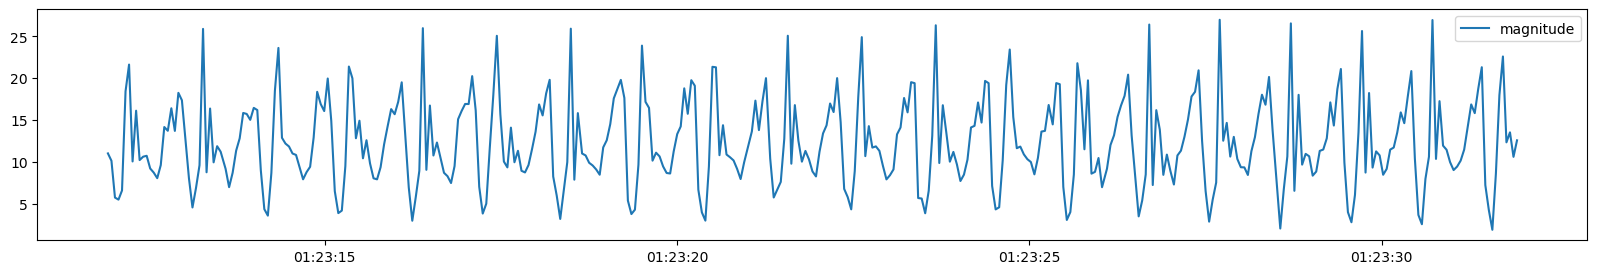

In [14]:
id = 1
segment = 1
df_user = data_df_sorted.loc[(data_df_sorted['user'] == id) & (data_df_sorted['segment'] == segment)]
activity = df_user['activity'].iloc[0]
print(f'activity type: {activity}')
fig, ax = plt.subplots(figsize=(20, 3))
first_timestamp = df_user['timestamp'].iloc[0]
end_timestamp = first_timestamp + np.timedelta64(20, 's')
df_user = df_user[(df_user['timestamp'] >= first_timestamp) & (df_user['timestamp'] <= end_timestamp)]
ax.plot(df_user['timestamp'], df_user['magnitude'], label='magnitude')
ax.legend(loc = 'upper right')

#### Check id=1's jogging data

activity type: Jogging


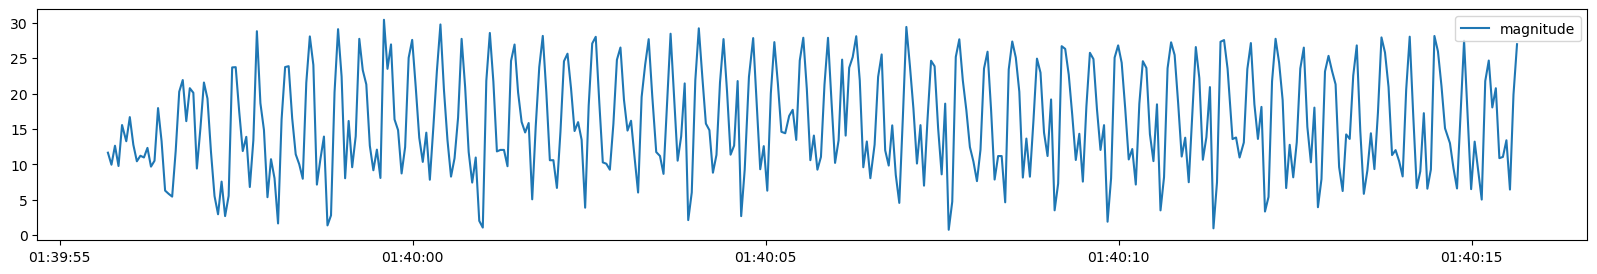

In [15]:
id = 1
segment = 5
df_user = data_df_sorted.loc[(data_df_sorted['user'] == id) & (data_df_sorted['segment'] == segment)]
activity = df_user['activity'].iloc[0]
print(f'activity type: {activity}')
fig, ax = plt.subplots(figsize=(20, 3))
first_timestamp = df_user['timestamp'].iloc[0]
end_timestamp = first_timestamp + np.timedelta64(20, 's')
df_user = df_user[(df_user['timestamp'] >= first_timestamp) & (df_user['timestamp'] <= end_timestamp)]
ax.plot(df_user['timestamp'], df_user['magnitude'], label='magnitude')
ax.legend(loc = 'upper right')

#### Check id=1's upstairs data

activity type: Upstairs


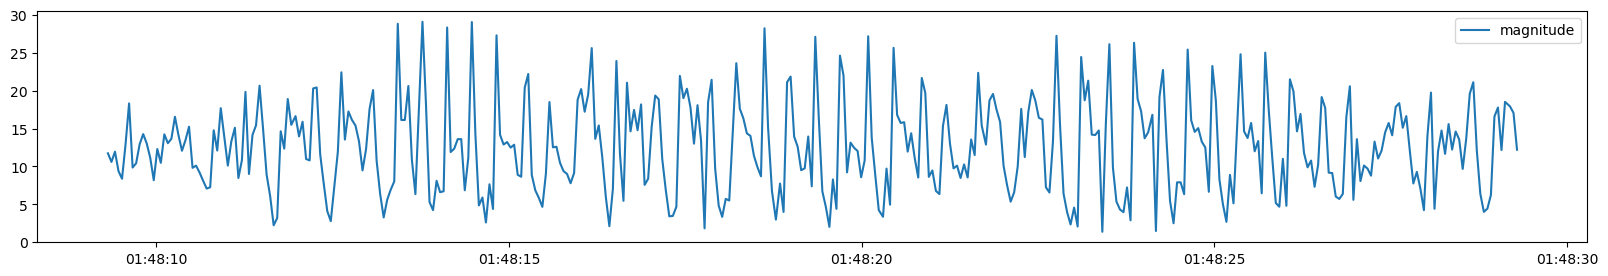

In [16]:
id = 1
segment = 6
df_user = data_df_sorted.loc[(data_df_sorted['user'] == id) & (data_df_sorted['segment'] == segment)]
activity = df_user['activity'].iloc[0]
print(f'activity type: {activity}')
fig, ax = plt.subplots(figsize=(20, 3))
first_timestamp = df_user['timestamp'].iloc[0]
end_timestamp = first_timestamp + np.timedelta64(20, 's')
df_user = df_user[(df_user['timestamp'] >= first_timestamp) & (df_user['timestamp'] <= end_timestamp)]
ax.plot(df_user['timestamp'], df_user['magnitude'], label='magnitude')
ax.legend(loc = 'upper right')

#### Check id=36's downstairs data

activity type: Downstairs


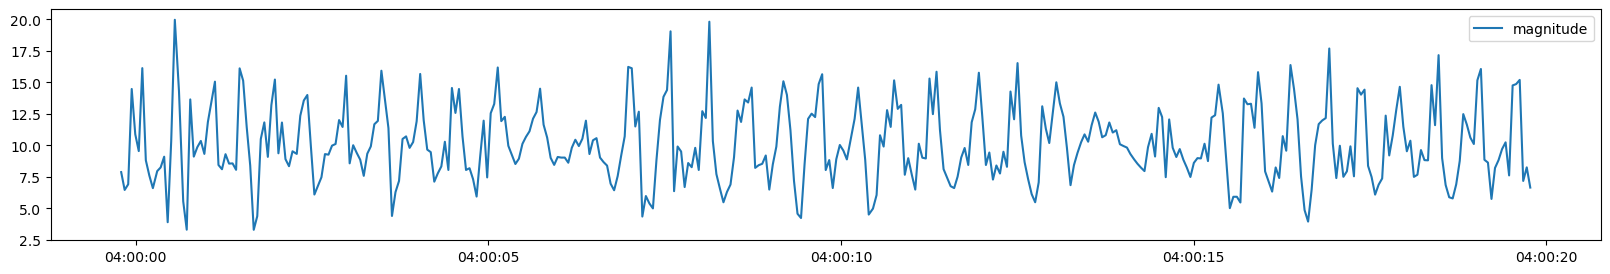

In [19]:
id = 36
segment = 7
df_user = data_df_sorted.loc[(data_df_sorted['user'] == id) & (data_df_sorted['segment'] == segment)]
activity = df_user['activity'].iloc[0]
print(f'activity type: {activity}')
fig, ax = plt.subplots(figsize=(20, 3))
first_timestamp = df_user['timestamp'].iloc[0]
end_timestamp = first_timestamp + np.timedelta64(20, 's')
df_user = df_user[(df_user['timestamp'] >= first_timestamp) & (df_user['timestamp'] <= end_timestamp)]
ax.plot(df_user['timestamp'], df_user['magnitude'], label='magnitude')
ax.legend(loc = 'upper right')

### Check id=36's sitting data

activity type: Sitting


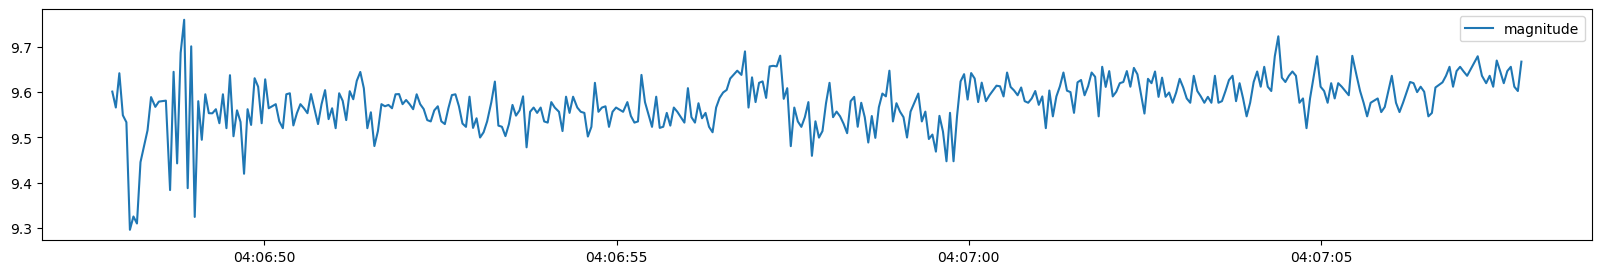

In [22]:
id = 36
segment = 12
df_user = data_df_sorted.loc[(data_df_sorted['user'] == id) & (data_df_sorted['segment'] == segment)]
activity = df_user['activity'].iloc[0]
print(f'activity type: {activity}')
fig, ax = plt.subplots(figsize=(20, 3))
first_timestamp = df_user['timestamp'].iloc[0]
end_timestamp = first_timestamp + np.timedelta64(20, 's')
df_user = df_user[(df_user['timestamp'] >= first_timestamp) & (df_user['timestamp'] <= end_timestamp)]
ax.plot(df_user['timestamp'], df_user['magnitude'], label='magnitude')
ax.legend(loc = 'upper right')

### Check id=36's standing data

activity type: Standing


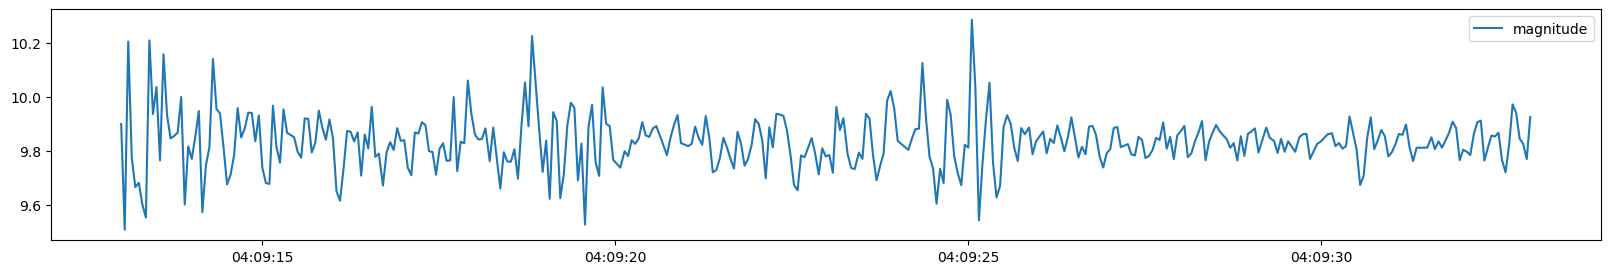

In [28]:
id = 36
segment = 13
df_user = data_df_sorted.loc[(data_df_sorted['user'] == id) & (data_df_sorted['segment'] == segment)]
activity = df_user['activity'].iloc[0]
print(f'activity type: {activity}')
fig, ax = plt.subplots(figsize=(20, 3))
first_timestamp = df_user['timestamp'].iloc[0]
end_timestamp = first_timestamp + np.timedelta64(20, 's')
df_user = df_user[(df_user['timestamp'] >= first_timestamp) & (df_user['timestamp'] <= end_timestamp)]
ax.plot(df_user['timestamp'], df_user['magnitude'], label='magnitude')
ax.legend(loc = 'upper right')